In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
from FSC import GenerationDiscreteObs as FSC_DiscreteObs
from FSC import InferenceDiscreteObs as FSC_InferenceDiscreteObs
import ObsModels 

In [4]:
# set matplotlib font to avenir
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'

# Finite State Controller with $M = 2$, $A = 2$, $Y = 2$

# Observations

In [4]:
NStepsObs = 100
NTraj = 200
Y = 2
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)
observations.shape

(200, 100)

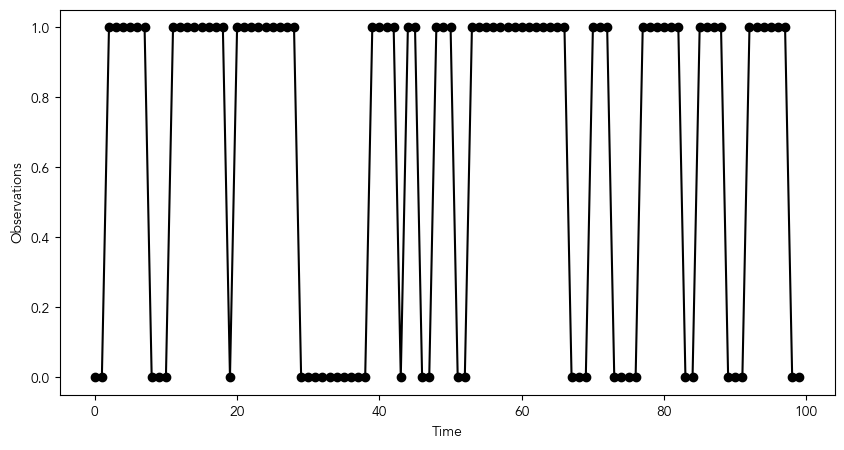

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

## Structured transition matrix

In [6]:
M = 2
A = 2

ThetaFollowSwitch = np.array([[[[10, 0.01], [0.01, 0.01]],
                               [[0.01, 0.01], [0.01, 10]]],
                              [[[0.01, 0.01], [0.01, 10]],
                               [[10, 0.01], [0.01, 0.01]]]])


Psi = np.array([1, 2])

FSC = FSC_DiscreteObs(ThetaFollowSwitch, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [7]:
FSC.load_observations(observations[:100])

In [8]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

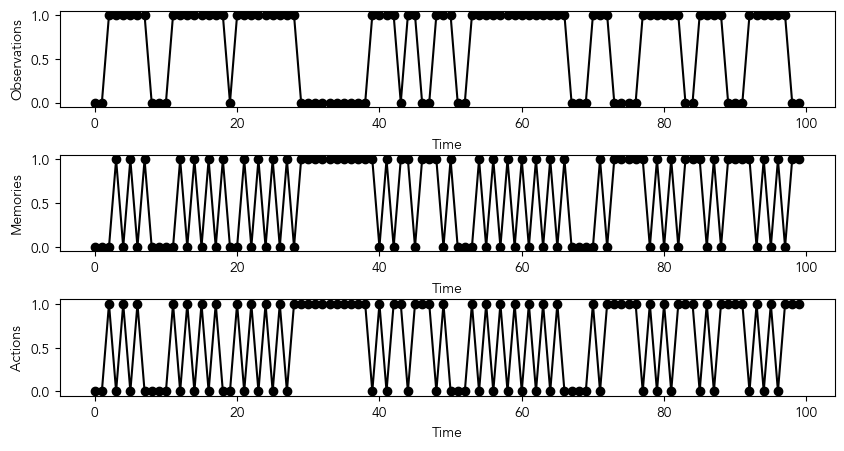

In [9]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [11]:
FSC.evaluate_nloglikelihood(trajectories[0])

1.3268468898572643

### Inference

In [20]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(74.0828, device='mps:0', grad_fn=<SubBackward0>)

In [21]:
tloss, vloss = FSC_tofit.optimize(NEpochs = 30, NBatch = 20, lr = 0.25, gamma = 0.9)

Training with 80 trajectories and validating with 20 trajectories.
	 Epoch 1 - Batch 1 - Loss: 68.9122802734375 - Learning rate: 0.25
	 Epoch 1 - Batch 2 - Loss: 62.4552734375 - Learning rate: 0.25
	 Epoch 1 - Batch 3 - Loss: 57.886322021484375 - Learning rate: 0.25
	 Epoch 1 - Batch 4 - Loss: 54.3461669921875 - Learning rate: 0.25
Epoch 1 - Training loss: 60.900010681152345, Validation loss: 51.89669494628906
	 Epoch 2 - Batch 1 - Loss: 48.71944580078125 - Learning rate: 0.225
	 Epoch 2 - Batch 2 - Loss: 44.80747985839844 - Learning rate: 0.225
	 Epoch 2 - Batch 3 - Loss: 39.12845153808594 - Learning rate: 0.225
	 Epoch 2 - Batch 4 - Loss: 31.674380493164062 - Learning rate: 0.225
Epoch 2 - Training loss: 41.08243942260742, Validation loss: 31.80351905822754
	 Epoch 3 - Batch 1 - Loss: 25.54395294189453 - Learning rate: 0.2025
	 Epoch 3 - Batch 2 - Loss: 20.500970458984376 - Learning rate: 0.2025
	 Epoch 3 - Batch 3 - Loss: 16.456407165527345 - Learning rate: 0.2025
	 Epoch 3 - Batch 

### Comparison

In [22]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


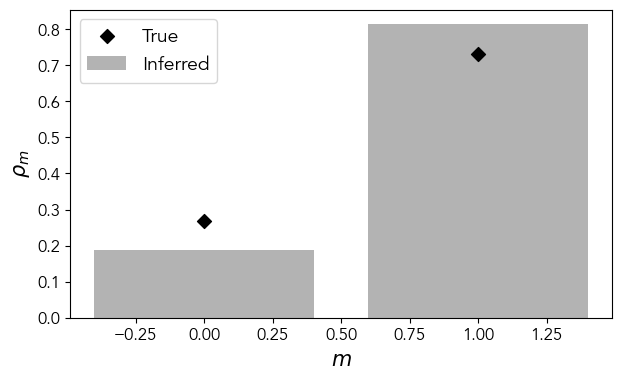

In [23]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC_inferred.rho, color = "dimgray", alpha = 0.5, label = "Inferred")
ax.scatter(np.arange(M), FSC.rho, color = "black", marker = "D", s = 50, label = "True")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14)

plt.show()

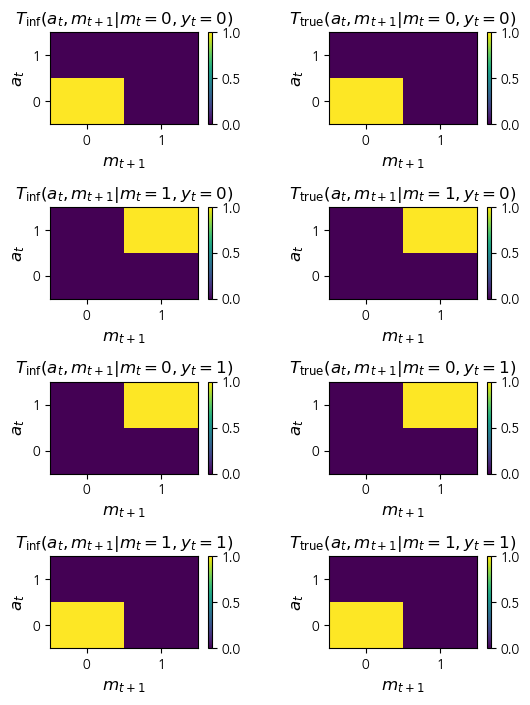

In [24]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,8))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [25]:
FSC_inferred.load_observations(observations)

In [26]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

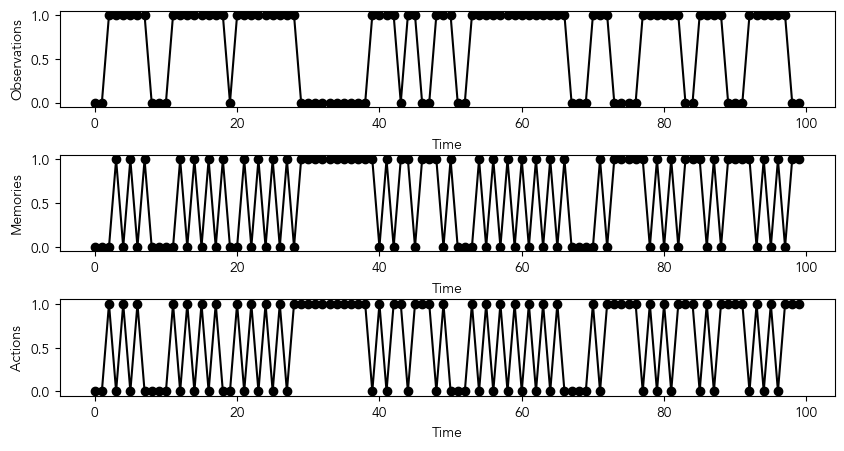

In [27]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

# $M = 2$, $A = 2$, $Y = 2$, random - working example

In [28]:
M = 2
A = 2

np.random.seed(7)

Theta = np.random.randn(Y, M, M, A)

Psi = np.random.randn(A)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [29]:
FSC.load_observations(observations)

In [30]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

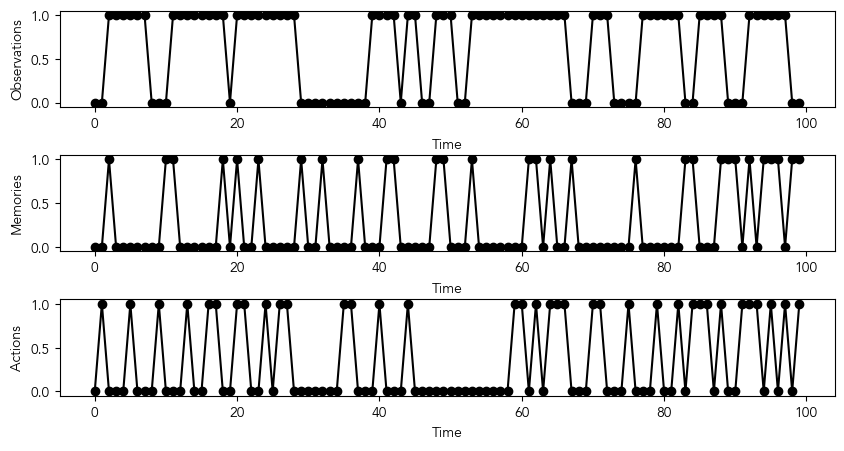

In [31]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [32]:
FSC.evaluate_nloglikelihood(trajectories[0])

63.67855498491081

### Inference

In [33]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123456789)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(71.4220, device='mps:0', grad_fn=<SubBackward0>)

In [34]:
tloss, vloss = FSC_tofit.optimize(NEpochs = 30, NBatch = 20, lr = 0.3, gamma = 0.9)

Training with 160 trajectories and validating with 40 trajectories.
	 Epoch 1 - Batch 1 - Loss: 70.75916748046875 - Learning rate: 0.3
	 Epoch 1 - Batch 2 - Loss: 65.90706176757813 - Learning rate: 0.3
	 Epoch 1 - Batch 3 - Loss: 67.50824584960938 - Learning rate: 0.3
	 Epoch 1 - Batch 4 - Loss: 66.80880126953124 - Learning rate: 0.3
	 Epoch 1 - Batch 5 - Loss: 65.4837158203125 - Learning rate: 0.3
	 Epoch 1 - Batch 6 - Loss: 67.04584350585938 - Learning rate: 0.3
	 Epoch 1 - Batch 7 - Loss: 66.73136596679687 - Learning rate: 0.3
	 Epoch 1 - Batch 8 - Loss: 65.76719970703125 - Learning rate: 0.3
Epoch 1 - Training loss: 67.00142517089844, Validation loss: 65.2675630569458
	 Epoch 2 - Batch 1 - Loss: 64.34353637695312 - Learning rate: 0.27
	 Epoch 2 - Batch 2 - Loss: 65.84603271484374 - Learning rate: 0.27
	 Epoch 2 - Batch 3 - Loss: 65.57855224609375 - Learning rate: 0.27
	 Epoch 2 - Batch 4 - Loss: 66.8270263671875 - Learning rate: 0.27
	 Epoch 2 - Batch 5 - Loss: 65.70911254882813 - 

### Comparison

In [35]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


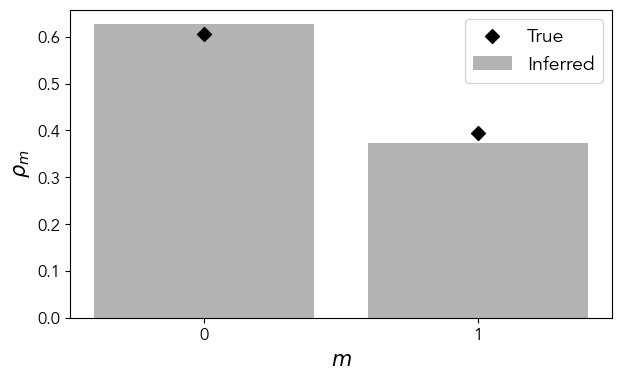

In [36]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC_inferred.rho, color = "dimgray", alpha = 0.5, label = "Inferred")
ax.scatter(np.arange(M), FSC.rho, color = "black", marker = "D", s = 50, label = "True")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(np.arange(M))

plt.legend(fontsize = 14)

plt.show()

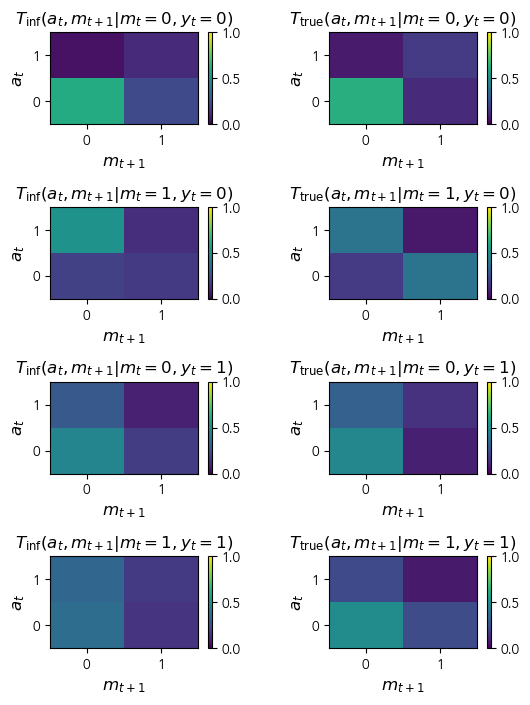

In [37]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,8))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [38]:
FSC_inferred.load_observations(observations)

In [39]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

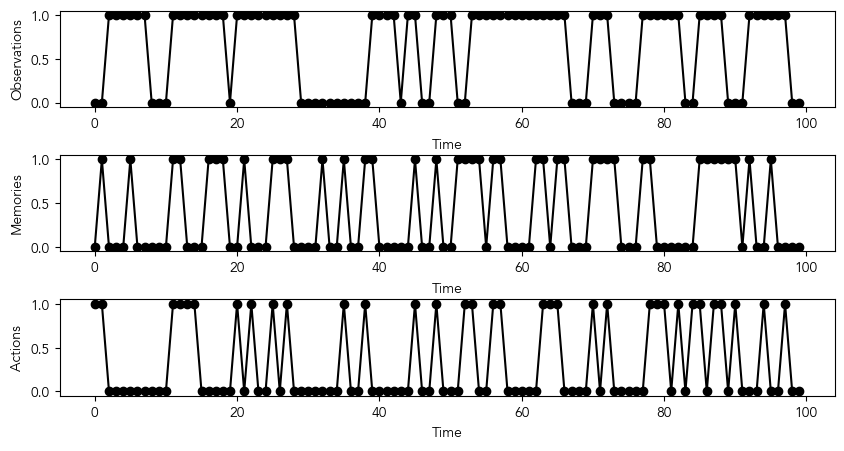

In [40]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

# $M = 2$, $A = 2$, $Y = 2$, random - harder example

In [41]:
M = 2
A = 2

np.random.seed(9)

Theta = np.random.randn(Y, M, M, A)

Psi = np.random.randn(A)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [42]:
FSC.load_observations(observations)

In [43]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

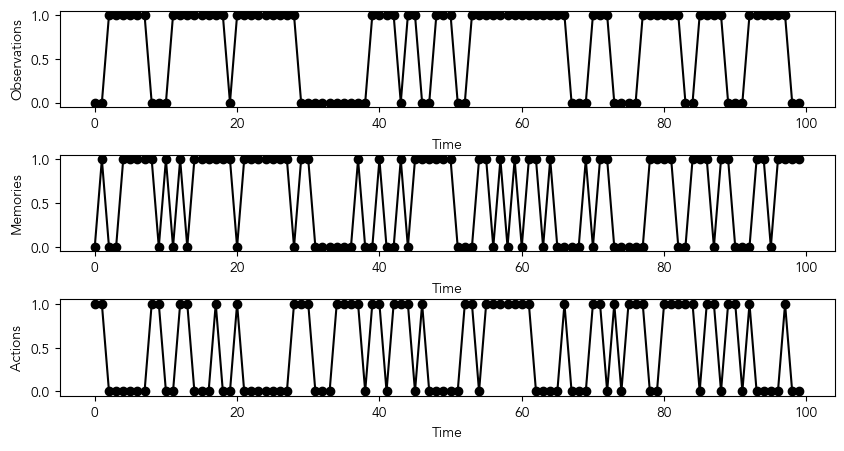

In [44]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [45]:
FSC.evaluate_nloglikelihood(trajectories[0])

66.7598793552936

### Inference

In [46]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123456789)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(78.1553, device='mps:0', grad_fn=<SubBackward0>)

In [47]:
tloss, vloss = FSC_tofit.optimize(NEpochs = 30, NBatch = 20, lr = 0.3, gamma = 0.9)

Training with 160 trajectories and validating with 40 trajectories.
	 Epoch 1 - Batch 1 - Loss: 76.255126953125 - Learning rate: 0.3
	 Epoch 1 - Batch 2 - Loss: 70.01923217773438 - Learning rate: 0.3
	 Epoch 1 - Batch 3 - Loss: 69.63751220703125 - Learning rate: 0.3
	 Epoch 1 - Batch 4 - Loss: 71.71997680664063 - Learning rate: 0.3
	 Epoch 1 - Batch 5 - Loss: 72.10784912109375 - Learning rate: 0.3
	 Epoch 1 - Batch 6 - Loss: 70.35928955078126 - Learning rate: 0.3
	 Epoch 1 - Batch 7 - Loss: 69.90662841796875 - Learning rate: 0.3
	 Epoch 1 - Batch 8 - Loss: 69.0330322265625 - Learning rate: 0.3
Epoch 1 - Training loss: 71.1298309326172, Validation loss: 69.01394233703613
	 Epoch 2 - Batch 1 - Loss: 68.78571166992188 - Learning rate: 0.27
	 Epoch 2 - Batch 2 - Loss: 69.39466552734375 - Learning rate: 0.27
	 Epoch 2 - Batch 3 - Loss: 69.57628784179687 - Learning rate: 0.27
	 Epoch 2 - Batch 4 - Loss: 69.53989868164062 - Learning rate: 0.27
	 Epoch 2 - Batch 5 - Loss: 69.34364013671875 - L

### Comparison

In [48]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

rho_sort = np.argsort(FSC.rho)

psi_sorted = FSC_inferred.psi[rho_sort]
theta_sorted = np.zeros_like(FSC_inferred.theta)

for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m1, m1 in enumerate(FSC_inferred.MemSpace):
        for idx_m2, m2 in enumerate(FSC_inferred.MemSpace):
            for idx_a, a in enumerate(FSC_inferred.ActSpace):
                theta_sorted[idx_y, idx_m1, idx_m2, idx_a] = FSC_inferred.theta[idx_y, rho_sort[idx_m1], rho_sort[idx_m2], idx_a]

FSC_inferred.load_theta(theta_sorted)
FSC_inferred.load_psi(psi_sorted)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


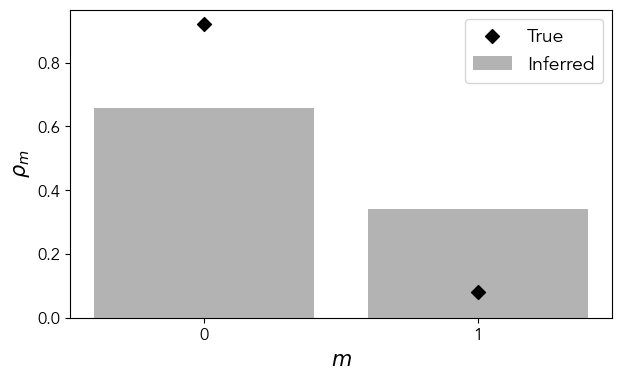

In [49]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC_inferred.rho, color = "dimgray", alpha = 0.5, label = "Inferred")
ax.scatter(np.arange(M), FSC.rho, color = "black", marker = "D", s = 50, label = "True")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(np.arange(M))

plt.legend(fontsize = 14)

plt.show()

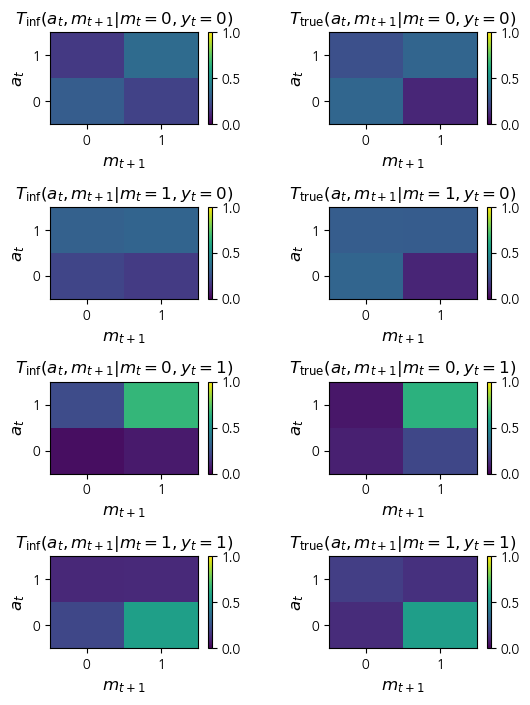

In [50]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,8))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [51]:
FSC_inferred.load_observations(observations)

In [52]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

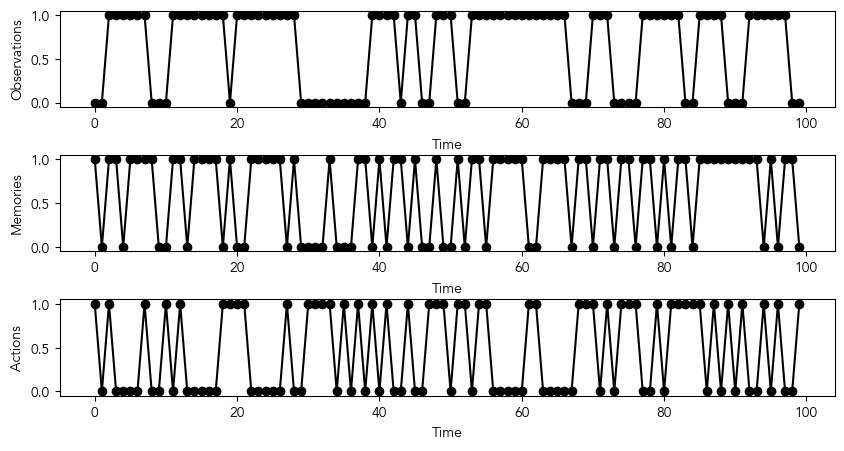

In [53]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

# $M = 2$, $A = 2$, $Y = 3$ with random transition matrix

In [5]:
NStepsObs = 100
NTraj = 200
Y = 3
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 5*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 42)
observations.shape

(200, 100)

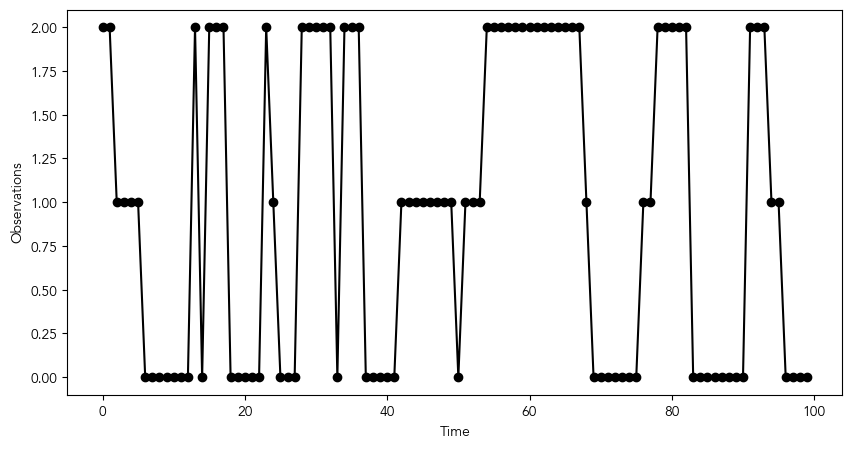

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [17]:
M = 2
A = 2
np.random.seed(3)
Theta = np.random.randn(Y, M, M, A)
Psi = np.random.randn(M)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 3 observations.


In [18]:
FSC.rho

array([0.42292145, 0.57707855])

In [19]:
FSC.load_observations(observations)

In [ ]:
sNSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

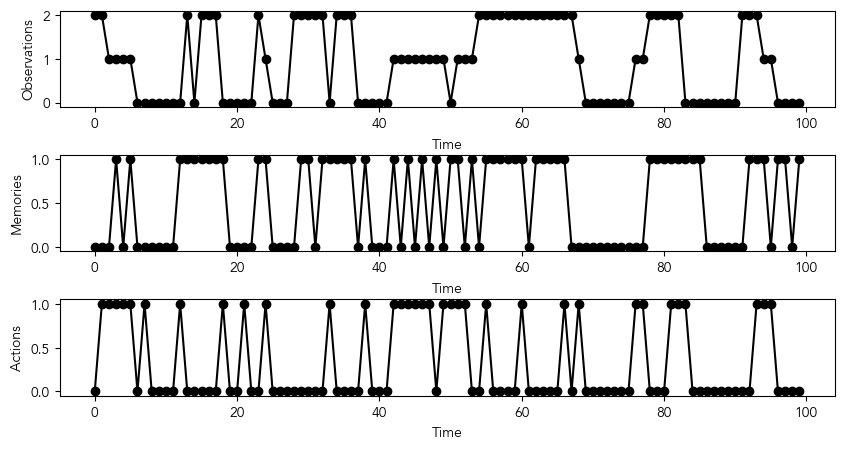

In [21]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [24]:
FSC.evaluate_nloglikelihood(trajectories[0])

47.218871470203275

### Inference

In [86]:
M = 2
A = 2
Y = 3

In [89]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 12345678)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)
FSC_tofit.rho

tensor([0.1687, 0.8313], device='mps:0', grad_fn=<SoftmaxBackward0>)

In [90]:
tloss, vloss = FSC_tofit.optimize(NEpochs = 10, NBatch = 20, lr = 0.25, gamma = 0.9)

Training with 160 trajectories and validating with 40 trajectories.


AttributeError: 'Parameter' object has no attribute 'training'

In [79]:
import torch
FSC_tofit.rho, FSC_tofit.psi, torch.nn.functional.normalize(torch.nn.functional.normalize(FSC_tofit.psi, p = 1, dim = 0), p = 1, dim = 0)

(tensor([0.7561, 0.2439], device='mps:0', grad_fn=<SoftmaxBackward0>),
 Parameter containing:
 tensor([ 0.9912, -0.1323], device='mps:0', requires_grad=True),
 tensor([ 0.8822, -0.1178], device='mps:0', grad_fn=<DivBackward0>))

### Comparison

In [83]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

rho_sort = [1,0]

psi_sorted = FSC_inferred.psi[rho_sort]
theta_sorted = np.zeros_like(FSC_inferred.theta)

for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m1, m1 in enumerate(FSC_inferred.MemSpace):
        for idx_m2, m2 in enumerate(FSC_inferred.MemSpace):
            for idx_a, a in enumerate(FSC_inferred.ActSpace):
                theta_sorted[idx_y, idx_m1, idx_m2, idx_a] = FSC_inferred.theta[idx_y, rho_sort[idx_m1], rho_sort[idx_m2], idx_a]

FSC_inferred.load_theta(theta_sorted)
FSC_inferred.load_psi(psi_sorted)

Initializing FSC with 2 memory states, 2 actions, and 3 observations.


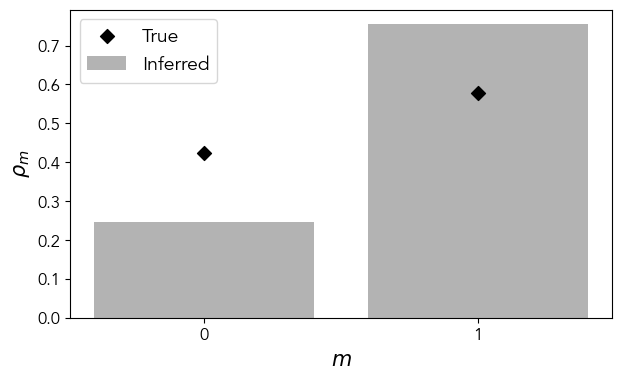

In [84]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC_inferred.rho, color = "dimgray", alpha = 0.5, label = "Inferred")
ax.scatter(np.arange(M), FSC.rho, color = "black", marker = "D", s = 50, label = "True")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(np.arange(M))

plt.legend(fontsize = 14)

plt.show()

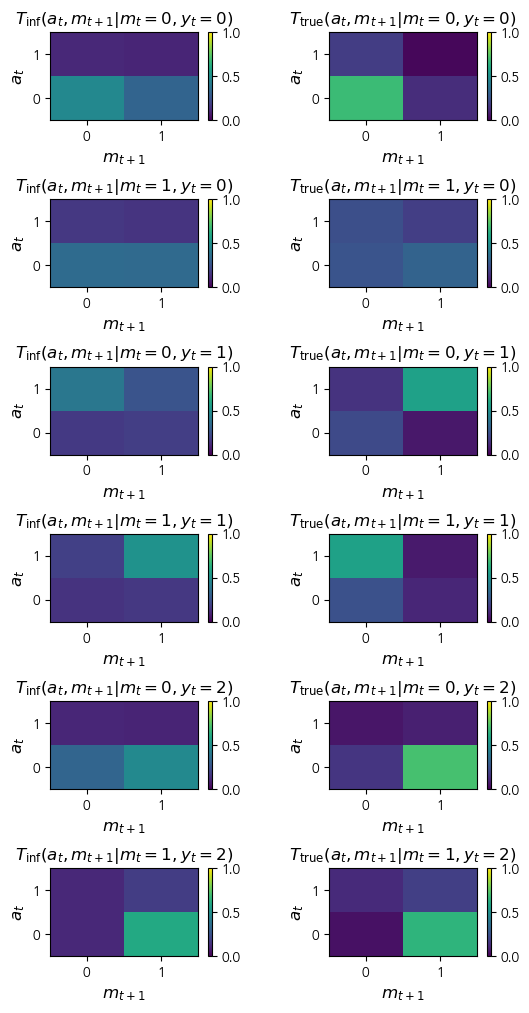

In [85]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,12))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

# $M = 2$, $A = 2$, $Y = 3$ with structured transition matrix

In [419]:
NStepsObs = 100
NTraj = 200
Y = 3
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 5*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 42)
observations.shape

(200, 100)

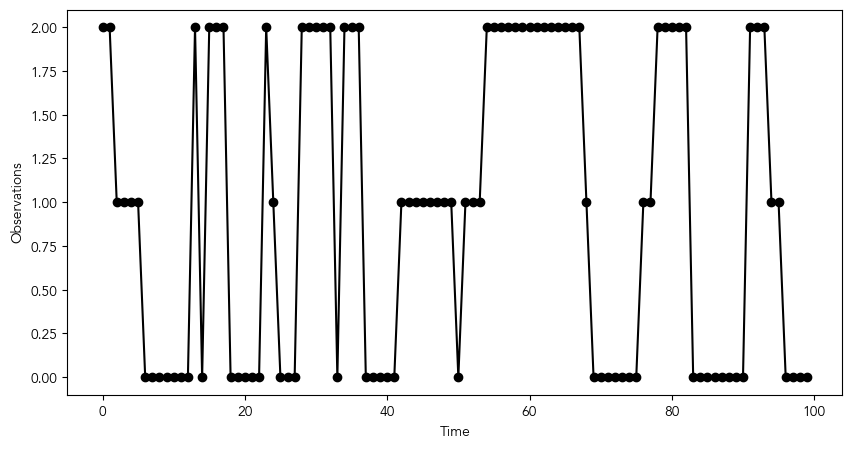

In [420]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [423]:
M = 2
A = 2

ThetaFollowSwitchFollow = np.zeros((Y, M, M, A))

# when receiving a zero observation, the memory is reset to zero and action 0 is taken
ThetaFollowSwitchFollow[0] = np.array([[[10, 0.1], [0.1, 0.1]],
                                      [[10, 0.1], [0.1, 0.1]]])

# when receiving a two observation, the memory is reset to one and action 1 is taken
ThetaFollowSwitchFollow[2] = np.array([[[0.1, 0.1], [0.1, 10]],
                                      [[0.1,0.1], [0.1, 10]]])

# when receiving a one observation, the memory keeps switching between 0 and 1 and the actions is random
ThetaFollowSwitchFollow[1] = np.array([[[0.1, 0.1], [10, 10]],
                                       [[10, 10], [0.1, 0.1]]])

Psi = np.array([1., 1.5])

FSC = FSC_DiscreteObs(ThetaFollowSwitchFollow, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 3 observations.


In [425]:
FSC.rho

array([0.37754067, 0.62245933])

In [426]:
FSC.load_observations(observations)

In [427]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

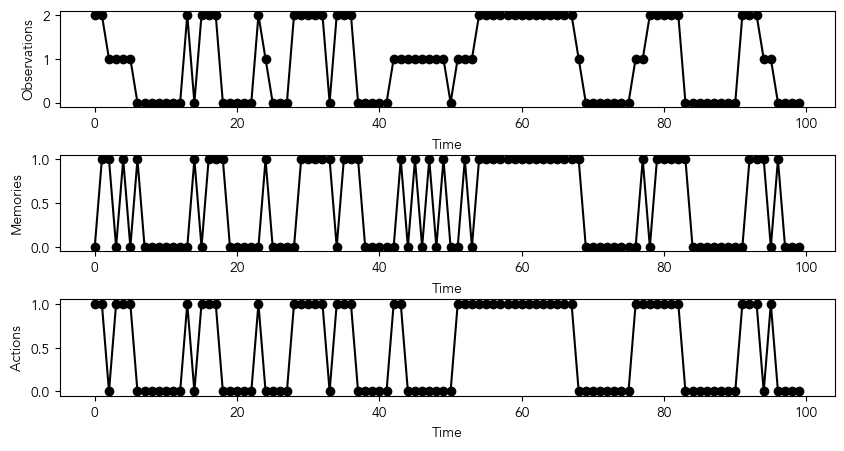

In [428]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [429]:
FSC.evaluate_nloglikelihood(trajectories[0])

14.564017596080621

### Inference

In [140]:
M = 2
A = 2
Y = 3

In [141]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123456789)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(72.6898, device='mps:0', grad_fn=<SubBackward0>)

In [142]:
tloss, vloss = FSC_tofit.optimize(NEpochs = 5, NBatch = 20, lr = 0.1, gamma = 0.9)

Training with 160 trajectories and validating with 40 trajectories.
	 Epoch 1 - Batch 1 - Loss: 74.86828002929687 - Learning rate: 0.1
	 Epoch 1 - Batch 2 - Loss: 67.64461669921874 - Learning rate: 0.1
	 Epoch 1 - Batch 3 - Loss: 59.942254638671876 - Learning rate: 0.1
	 Epoch 1 - Batch 4 - Loss: 54.017828369140624 - Learning rate: 0.1
	 Epoch 1 - Batch 5 - Loss: 50.620916748046874 - Learning rate: 0.1
	 Epoch 1 - Batch 6 - Loss: 48.07642517089844 - Learning rate: 0.1
	 Epoch 1 - Batch 7 - Loss: 45.759646606445315 - Learning rate: 0.1
	 Epoch 1 - Batch 8 - Loss: 40.01243286132812 - Learning rate: 0.1
Epoch 1 - Training loss: 55.11780014038086, Validation loss: 40.48309416770935
	 Epoch 2 - Batch 1 - Loss: 36.75755310058594 - Learning rate: 0.09000000000000001
	 Epoch 2 - Batch 2 - Loss: 35.750115966796876 - Learning rate: 0.09000000000000001
	 Epoch 2 - Batch 3 - Loss: 32.17572021484375 - Learning rate: 0.09000000000000001
	 Epoch 2 - Batch 4 - Loss: 31.096832275390625 - Learning rate:

### Comparison

In [143]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

rho_sort = np.argsort(FSC.rho)

psi_sorted = FSC_inferred.psi[rho_sort]
theta_sorted = np.zeros_like(FSC_inferred.theta)

for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m1, m1 in enumerate(FSC_inferred.MemSpace):
        for idx_m2, m2 in enumerate(FSC_inferred.MemSpace):
            for idx_a, a in enumerate(FSC_inferred.ActSpace):
                theta_sorted[idx_y, idx_m1, idx_m2, idx_a] = FSC_inferred.theta[idx_y, rho_sort[idx_m1], rho_sort[idx_m2], idx_a]

FSC_inferred.load_theta(theta_sorted)
FSC_inferred.load_psi(psi_sorted)

Initializing FSC with 2 memory states, 2 actions, and 3 observations.


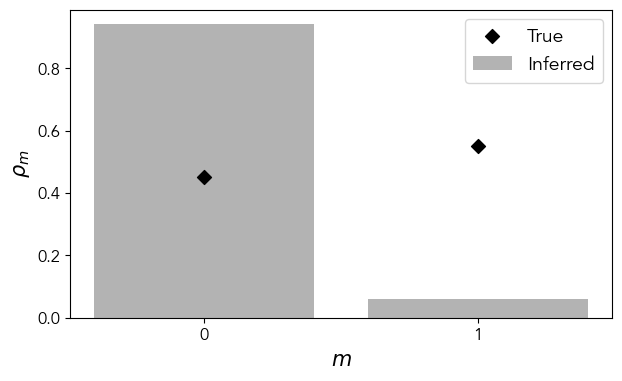

In [144]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC_inferred.rho, color = "dimgray", alpha = 0.5, label = "Inferred")
ax.scatter(np.arange(M), FSC.rho, color = "black", marker = "D", s = 50, label = "True")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(np.arange(M))

plt.legend(fontsize = 14)

plt.show()

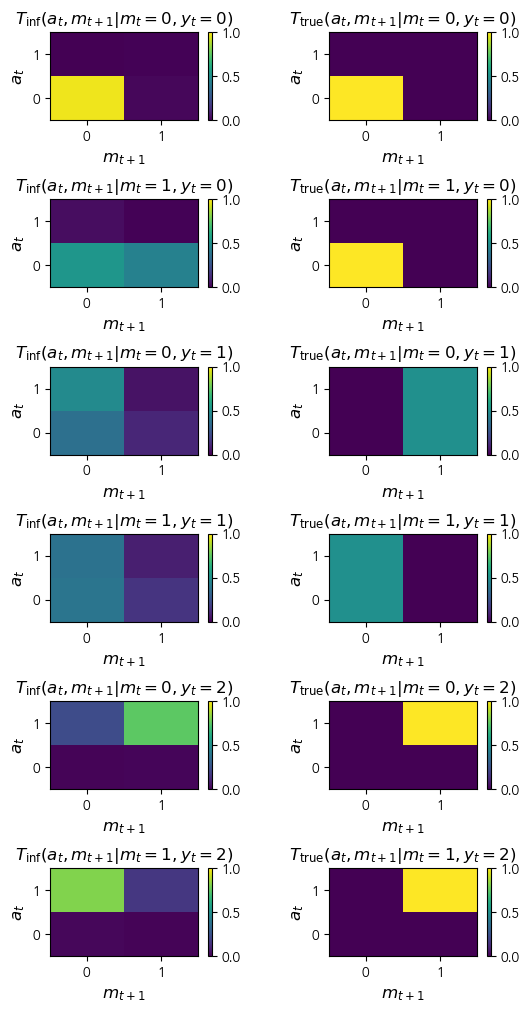

In [145]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,12))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [152]:
idx = 6
t = 0

y = trajectories[idx]["observations"][t]
a = trajectories[idx]["actions"][t]
m = trajectories[idx]["memories"][t]
y, a, m

(0, 0, 1)

In [161]:
trajectories[idx]["memories"][t+1]

0

In [153]:
current_TMat = FSC.TMat[y, :, :, a]
current_TMat_inf = FSC_inferred.TMat[y, :, :, a]

In [156]:
current_TMat

array([[9.99849499e-01, 5.01671307e-05],
       [9.99849499e-01, 5.01671307e-05]])

In [157]:
current_TMat_inf

array([[0.97374926, 0.01915104],
       [0.52408465, 0.43592516]])

In [162]:
current_TMat[m], current_TMat_inf[m]

(array([9.99849499e-01, 5.01671307e-05]), array([0.52408465, 0.43592516]))

In [301]:
FSC_inferred.load_observations(observations)

In [302]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

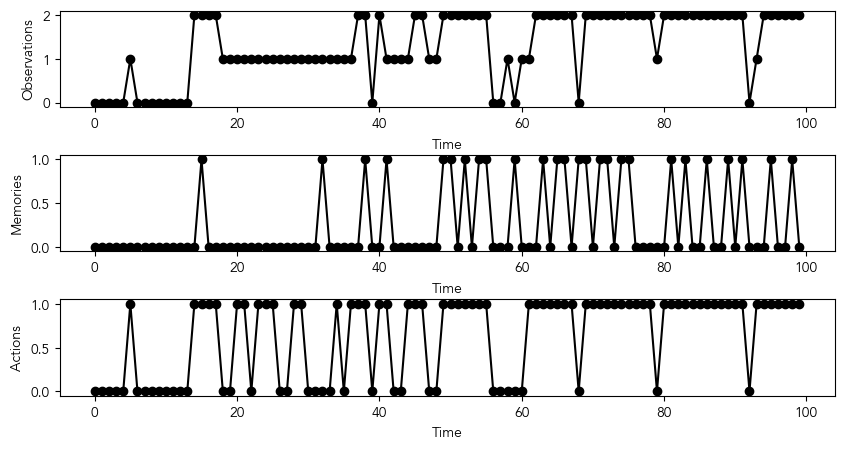

In [303]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

# Feed the correct Theta and optimize only Psi

In [440]:
dict_keys = ["memories", "actions", "observations"]
trajectories_twosteps = []

for tr in trajectories:
    tr_ts = {}
    for k in dict_keys:
        tr_ts[k] = tr[k][:1]

    trajectories_twosteps.append(tr_ts)

In [441]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 12345678)
FSC_tofit.load_theta(ThetaFollowSwitchFollow.astype(np.float32))
FSC_tofit.load_trajectories(trajectories_twosteps)
#FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

In [442]:
FSC_tofit.psi, FSC_tofit.rho

(Parameter containing:
 tensor([-0.4697,  1.1254], device='mps:0', requires_grad=True),
 tensor([0.1687, 0.8313], device='mps:0', grad_fn=<SoftmaxBackward0>))

In [443]:
FSC_tofit.TMat[0, :, :, 0].sum()

tensor(1.9998, device='mps:0', grad_fn=<SumBackward0>)

In [444]:
FSC_tofit.TMat

tensor([[[[9.9985e-01, 5.0167e-05],
          [5.0167e-05, 5.0167e-05]],

         [[9.9985e-01, 5.0167e-05],
          [5.0167e-05, 5.0167e-05]]],


        [[[2.5086e-05, 2.5086e-05],
          [4.9997e-01, 4.9997e-01]],

         [[4.9997e-01, 4.9997e-01],
          [2.5086e-05, 2.5086e-05]]],


        [[[5.0167e-05, 5.0167e-05],
          [5.0167e-05, 9.9985e-01]],

         [[5.0167e-05, 5.0167e-05],
          [5.0167e-05, 9.9985e-01]]]], device='mps:0', grad_fn=<DivBackward0>)

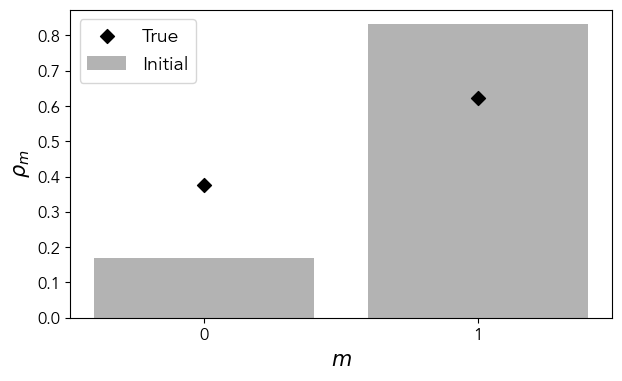

In [445]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC_tofit.rho.detach().cpu(), color = "dimgray", alpha = 0.5, label = "Initial")
ax.scatter(np.arange(M), FSC.rho, color = "black", marker = "D", s = 50, label = "True")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(np.arange(M))

plt.legend(fontsize = 14)

plt.show()

In [532]:
import torch

In [540]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 12334)
FSC_tofit.load_theta(ThetaFollowSwitchFollow.astype(np.float32))
FSC_tofit.load_trajectories(trajectories_twosteps)
FSC_tofit.psi = torch.tensor([0.99, 1.51], requires_grad = True, device = FSC_tofit.device)
FSC_tofit.psi, FSC_tofit.rho

(tensor([0.9900, 1.5100], device='mps:0', requires_grad=True),
 tensor([0.3733, 0.6267], device='mps:0', grad_fn=<SoftmaxBackward0>))

In [541]:
tloss, vloss = FSC_tofit.optimize_psionly(NEpochs = 20, NBatch = 40, lr = 0.1, gamma = 0.9, lam = 0)

Training with 160 trajectories and validating with 40 trajectories.
	 Epoch 1 - Batch 1 - Loss: 0.31197152137756345 - Learning rate: 0.1
	 Epoch 1 - Batch 2 - Loss: 0.1213836908340454 - Learning rate: 0.1
	 Epoch 1 - Batch 3 - Loss: 0.3119715690612793 - Learning rate: 0.1
	 Epoch 1 - Batch 4 - Loss: 0.17336220741271974 - Learning rate: 0.1
Epoch 1 - Training loss: 0.229672247171402, Validation loss: 0.17336213966882497
	 Epoch 2 - Batch 1 - Loss: 0.25999300479888915 - Learning rate: 0.09000000000000001
	 Epoch 2 - Batch 2 - Loss: 0.2253406286239624 - Learning rate: 0.09000000000000001
	 Epoch 2 - Batch 3 - Loss: 0.2773191690444946 - Learning rate: 0.09000000000000001
	 Epoch 2 - Batch 4 - Loss: 0.15603600740432738 - Learning rate: 0.09000000000000001
Epoch 2 - Training loss: 0.22967220246791836, Validation loss: 0.17336213966882497
	 Epoch 3 - Batch 1 - Loss: 0.15603597164154054 - Learning rate: 0.08100000000000002
	 Epoch 3 - Batch 2 - Loss: 0.32929766178131104 - Learning rate: 0.0810

In [542]:
FSC_tofit.psi, FSC_tofit.rho

(tensor([0.9900, 1.5100], device='mps:0', requires_grad=True),
 tensor([0.3729, 0.6271], device='mps:0', grad_fn=<SoftmaxBackward0>))

In [530]:
FSC.psi

array([1. , 1.5])

In [525]:
FSC.rho

array([0.37754067, 0.62245933])

In [190]:
idx = 4

y = trajectories_twosteps[idx]["observations"][0]
a = trajectories_twosteps[idx]["actions"][0]
m = trajectories_twosteps[idx]["memories"][0]
y, a, m

(1, 1, 1)

In [191]:
current_TMat = FSC.TMat[y, :, :, a]
rho_real = FSC.rho.copy()
rho_infer = FSC_tofit.rho.detach().cpu().numpy()
current_TMat, rho_real, rho_infer

(array([[2.50860823e-05, 4.99974914e-01],
        [4.99974914e-01, 2.50860823e-05]]),
 array([0.450166, 0.549834]),
 array([0.16733621, 0.8326638 ], dtype=float32))

In [196]:
- np.log(np.sum(current_TMat.T @ rho_real))

0.6931471805599454

In [197]:
- np.log(np.sum(current_TMat.T @ rho_infer))

0.6931471954611066

In [176]:
ThetaFollowSwitchFollow[1, :, :, 0], ThetaFollowSwitchFollow[1, :, :, 1]

(array([[ 0.1, 10. ],
        [10. ,  0.1]]),
 array([[ 0.1, 10. ],
        [10. ,  0.1]]))

In [149]:
ThetaFollowSwitchFollow[2, :, :, 0], ThetaFollowSwitchFollow[2, :, :, 1]

(array([[0.01, 0.01],
        [0.01, 0.01]]),
 array([[ 0.01, 10.  ],
        [ 0.01, 10.  ]]))

In [143]:
import fun
import torch
from torch import nn

device = torch.device("mps")
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 12345678)
FSC_tofit.load_theta(ThetaFollowSwitchFollow.astype(np.float32))
FSC_tofit.load_trajectories(trajectories_twosteps)
print("Psi before optimization:", FSC_tofit.psi)
tloss, vloss = FSC_tofit.optimize_psionly(NEpochs = 1, NBatch = 160, lr = 0.1, gamma = 0.9)
print("Psi after optimization:", FSC_tofit.psi)


def lossfun(TMat, rho, observations, actions, grad_required=True):
    nLL = torch.tensor(0.0, requires_grad = grad_required)

    for t in range(observations.size(0)):
        idx_a = actions[t]
        idx_obs = observations[t]

        transition_probs = TMat[idx_obs, :, :, idx_a].T

        if t == 0:
            m = torch.matmul(transition_probs, rho)
        else:
            m = torch.matmul(transition_probs, m)

        mv = torch.sum(m)
        nLL = nLL - torch.log(mv)
        m /= mv

    return nLL - torch.log(torch.sum(m))


# Ensure psi has requires_grad=True and is on the correct device

FSC_tofit.optimizer.zero_grad()
loss = torch.tensor(0.0, requires_grad=True, device=device)

idx = 0
NBatch = 160
NTrain = 160
trjs_train = FSC_tofit.ObsAct_trajectories[:NTrain]
count = 0

FSC_tofit.rho = nn.Softmax(dim = 0)(FSC_tofit.psi)
FSC_tofit.TMat = fun.torch_softmax_2dim(FSC_tofit.theta, dims = (2, 3))

for idx_traj in range(idx, idx + NBatch):
    observations = trjs_train[idx_traj][0].to(device)
    actions = trjs_train[idx_traj][1].to(device)
    loss_traj = lossfun(FSC_tofit.TMat, FSC_tofit.psi, observations, actions)
    #loss_traj = FSC_tofit.loss(trjs_train[idx_traj][0], trjs_train[idx_traj][1])
    loss = loss + loss_traj
    count += 1

# Print intermediate values to debug
print()
print("Loss before backward:", loss.item())
print("Psi before backward:", FSC_tofit.psi)
print("Psi Grad before backward:", FSC_tofit.psi.grad)
print()
loss.backward()

# Print gradients to check if they are non-zero
print("Loss after backward:", loss.item())
print("Psi after backward:", FSC_tofit.psi)
print("Psi Grad after backward:", FSC_tofit.psi.grad)
print()

FSC_tofit.optimizer.step()

# Print psi after optimizer step
print("Psi after step:", FSC_tofit.psi)


Psi before optimization: Parameter containing:
tensor([-0.4697,  1.1254], device='mps:0', requires_grad=True)
Training with 160 trajectories and validating with 40 trajectories.
	 Epoch 1 - Batch 1 - Loss: 0.22966630458831788 - Learning rate: 0.1
Epoch 1 - Training loss: 0.22966630458831788, Validation loss: 0.17335559743150952
Psi after optimization: Parameter containing:
tensor([-0.4697,  1.1254], device='mps:0', requires_grad=True)

Loss before backward: 104.27423095703125
Psi before backward: Parameter containing:
tensor([-0.4697,  1.1254], device='mps:0', requires_grad=True)
Psi Grad before backward: None

Loss after backward: 104.27423095703125
Psi after backward: Parameter containing:
tensor([-0.4697,  1.1254], device='mps:0', requires_grad=True)
Psi Grad after backward: tensor([-244.0131, -244.0131], device='mps:0')

Psi after step: Parameter containing:
tensor([-0.4027,  1.1923], device='mps:0', requires_grad=True)


In [43]:
FSC_tofit.rho

tensor([0.1687, 0.8313], device='mps:0', grad_fn=<SoftmaxBackward0>)

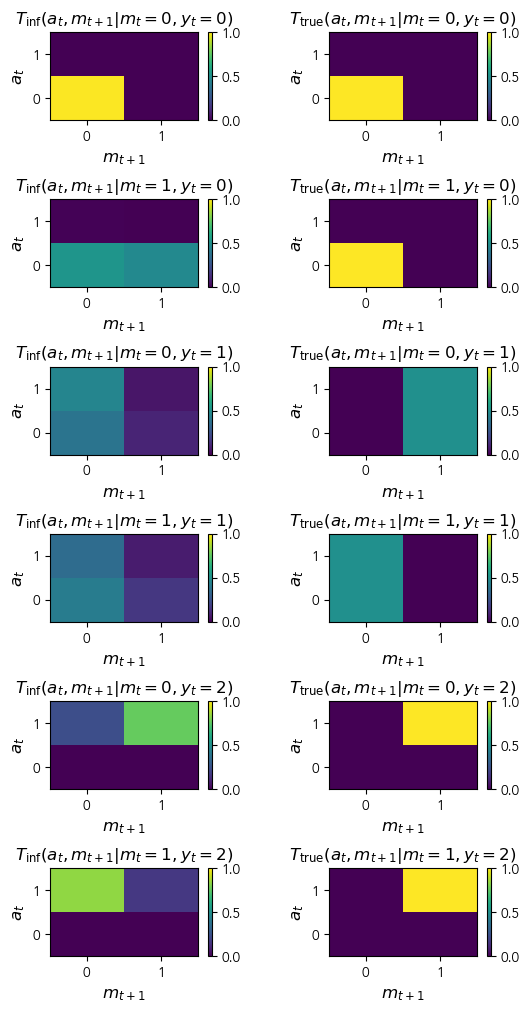

In [ ]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,12))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [269]:
psi = nn.Parameter(torch.tensor([1.0, 1.0], requires_grad = True, device = "mps"))

optimizer = torch.optim.Adam([psi], lr = 0.5)
optimizer.zero_grad()
loss = torch.tensor(0.0, requires_grad = True)

TMat = fun.torch_softmax_2dim(FSC_tofit.theta, dims = (2, 3))
rho = nn.Softmax(dim = 0)(psi)
idx = 0
NBatch = 80
NTrain = 80
trjs_train = FSC_tofit.ObsAct_trajectories[:NTrain]
count = 0

for idx_traj in range(idx, idx + NBatch):
    if idx_traj < NTrain:
        # here we go without the custom space for simplicity
        loss_traj = lossfun(TMat, rho, trjs_train[idx_traj][0], trjs_train[idx_traj][1])
        loss = loss + loss_traj
        count += 1

loss.backward()
optimizer.step()
loss, psi, psi.grad

(tensor(15.9476, device='mps:0', grad_fn=<AddBackward0>),
 Parameter containing:
 tensor([1., 1.], device='mps:0', requires_grad=True),
 tensor([0., 0.], device='mps:0'))

In [248]:
FSC_tofit.psi, FSC_tofit.rho

(Parameter containing:
 tensor([-0.4697,  1.1254], device='mps:0', requires_grad=True),
 tensor([0.1687, 0.8313], device='mps:0', grad_fn=<SoftmaxBackward0>))

In [222]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)
print(FSC_inferred.psi)
rho_sort = np.argsort(FSC.rho)

psi_sorted = FSC_inferred.psi[rho_sort]
theta_sorted = np.zeros_like(FSC_inferred.theta)

for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m1, m1 in enumerate(FSC_inferred.MemSpace):
        for idx_m2, m2 in enumerate(FSC_inferred.MemSpace):
            for idx_a, a in enumerate(FSC_inferred.ActSpace):
                theta_sorted[idx_y, idx_m1, idx_m2, idx_a] = FSC_inferred.theta[idx_y, rho_sort[idx_m1], rho_sort[idx_m2], idx_a]

FSC_inferred.load_theta(theta_sorted)
FSC_inferred.load_psi(psi_sorted)

Initializing FSC with 2 memory states, 2 actions, and 3 observations.
[-0.46967405  1.12537754]


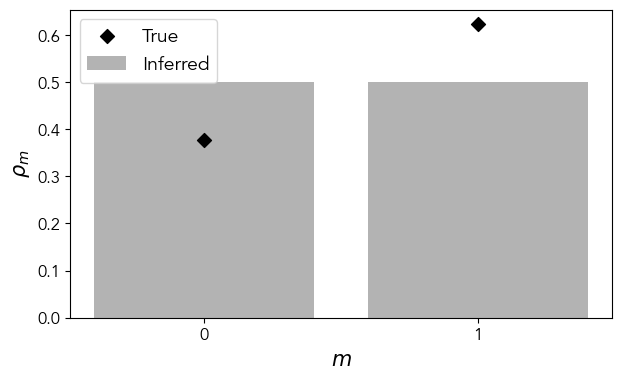

In [199]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC_inferred.rho, color = "dimgray", alpha = 0.5, label = "Inferred")
ax.scatter(np.arange(M), FSC.rho, color = "black", marker = "D", s = 50, label = "True")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(np.arange(M))

plt.legend(fontsize = 14)

plt.show()

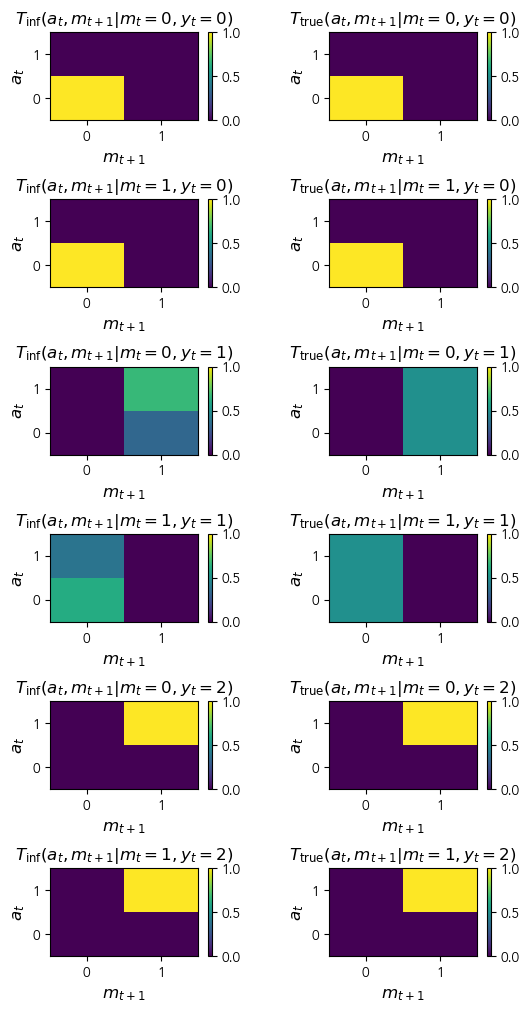

In [176]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,12))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

# Old trials

In [367]:
NStepsObs = 100
NTraj = 200
Y = 2
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)
observations.shape

(200, 100)

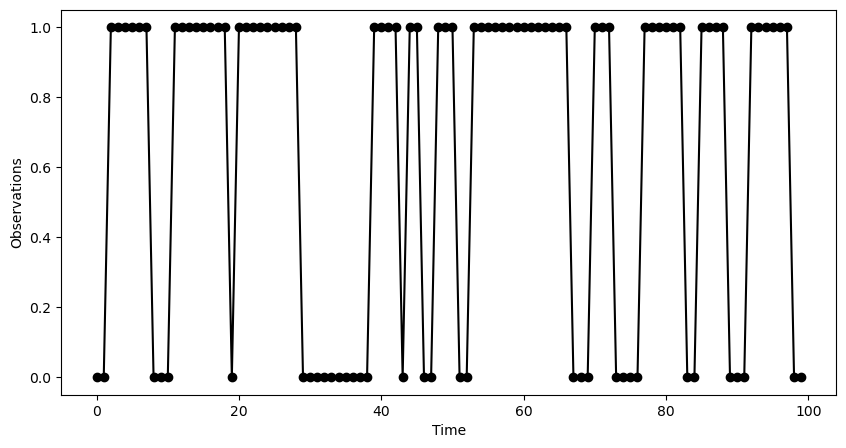

In [368]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [369]:
M = 2
A = 2
Theta = np.random.randn(Y, M, M, A)

Psi = np.random.randn(A)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [370]:
FSC.TMat, FSC.rho

(array([[[[0.51808768, 0.13839864],
          [0.16792747, 0.17558622]],
 
         [[0.11801551, 0.01081491],
          [0.02991096, 0.84125862]]],
 
 
        [[[0.6704419 , 0.03702521],
          [0.24360295, 0.04892994]],
 
         [[0.67139756, 0.10604617],
          [0.09567751, 0.12687876]]]]),
 array([0.08528574, 0.91471426]))

In [371]:
FSC.load_observations(observations)

In [372]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

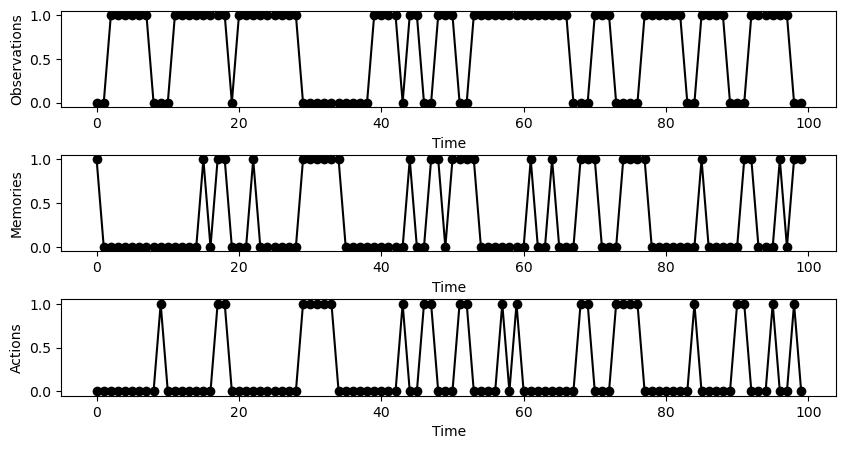

In [373]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = plt.subplots(3,1, figsize=(10,5))
plt.subplots_adjust(hspace=0.5)

ax[0].plot(Time, trj["observations"], 'o', c= 'k')
ax[0].plot(Time, trj["observations"], c = 'k')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Observations')

ax[1].plot(Time, trj["memories"], 'o', c= 'k')
ax[1].plot(Time, trj["memories"], c = 'k')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Memories')

ax[2].plot(Time, trj["actions"], 'o', c= 'k')
ax[2].plot(Time, trj["actions"], c = 'k')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Actions')

plt.show()

In [374]:
FSC.evaluate_nloglikelihood(trajectories[0])

42.107698064052315

In [421]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(41.0647, device='mps:0', grad_fn=<SubBackward0>)

In [422]:
FSC_tofit.TMat.detach().cpu().numpy()[0][0], FSC.TMat[0][0]

(array([[0.5180877 , 0.13839863],
        [0.16792747, 0.17558621]], dtype=float32),
 array([[0.51808768, 0.13839864],
        [0.16792747, 0.17558622]]))

In [423]:
_, _ = FSC_tofit.optimize_psionly(NEpochs = 10, NBatch = 40, lr = 0.1, gamma = 0.9)

Training with 160 trajectories and validating with 40 trajectories.
	 Epoch 1 - Batch 1 - Loss: 49.867767333984375 - Learning rate: 0.1
	 Epoch 1 - Batch 2 - Loss: 50.897918701171875 - Learning rate: 0.1
	 Epoch 1 - Batch 3 - Loss: 49.77183227539062 - Learning rate: 0.1
	 Epoch 1 - Batch 4 - Loss: 51.01481628417969 - Learning rate: 0.1
Epoch 1 - Training loss: 50.38808364868164, Validation loss: 50.27743072509766
	 Epoch 2 - Batch 1 - Loss: 48.92837219238281 - Learning rate: 0.09000000000000001
	 Epoch 2 - Batch 2 - Loss: 50.5696533203125 - Learning rate: 0.09000000000000001
	 Epoch 2 - Batch 3 - Loss: 50.650003051757814 - Learning rate: 0.09000000000000001
	 Epoch 2 - Batch 4 - Loss: 51.08540344238281 - Learning rate: 0.09000000000000001
Epoch 2 - Training loss: 50.30835800170898, Validation loss: 50.20161848068237
	 Epoch 3 - Batch 1 - Loss: 50.636288452148435 - Learning rate: 0.08100000000000002
	 Epoch 3 - Batch 2 - Loss: 50.48311767578125 - Learning rate: 0.08100000000000002
	 Epo

In [424]:
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(42.0940, device='mps:0', grad_fn=<SubBackward0>)

In [425]:
FSC_tofit.rho.detach().cpu().numpy(), FSC.rho

(array([0.09044039, 0.9095596 ], dtype=float32),
 array([0.08528574, 0.91471426]))

In [426]:
FSC_tofit.TMat.detach().cpu().numpy()[0][0][0], FSC.TMat[0][0][0]

(array([0.5180877 , 0.13839863], dtype=float32),
 array([0.51808768, 0.13839864]))

In [385]:
FSC_tofit.TMat.detach().cpu().numpy()[0][0][1], FSC.TMat[0][1][0]

(array([0.16792747, 0.17558621], dtype=float32),
 array([0.11801551, 0.01081491]))

In [387]:
FSC_tofit.TMat.detach().cpu().numpy()[1], FSC.TMat[1]

(array([[[0.6704419 , 0.03702521],
         [0.24360295, 0.04892994]],
 
        [[0.67139757, 0.10604617],
         [0.0956775 , 0.12687875]]], dtype=float32),
 array([[[0.6704419 , 0.03702521],
         [0.24360295, 0.04892994]],
 
        [[0.67139756, 0.10604617],
         [0.09567751, 0.12687876]]]))

# $M = 2$, $A = 2$, $Y = 3$

In [223]:
NStepsObs = 200
NTraj = 100
Y = 3
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 25*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 42)
observations.shape

(100, 200)

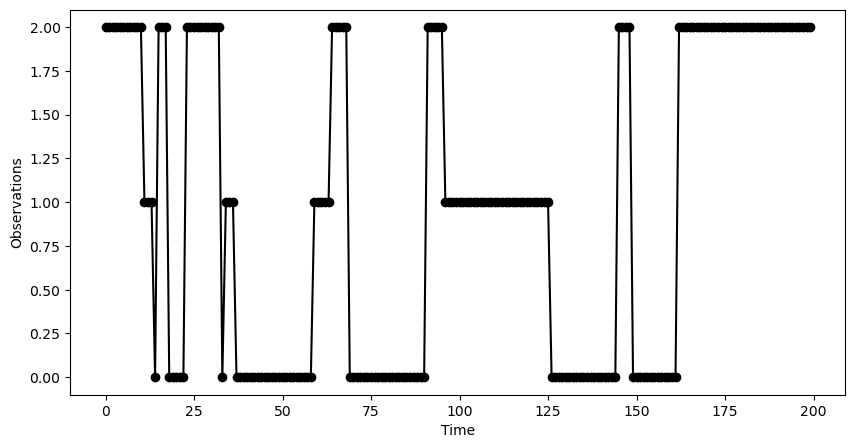

In [224]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [225]:
M = 2
A = 2
#Theta = np.random.randn(Y, M, M, A)

ThetaFollowSwitchFollow = np.zeros((Y, M, M, A))

# when receiving a zero observation, the memory is reset to zero and action 0 is taken
ThetaFollowSwitchFollow[0] = np.array([[[10, 0.01], [0.01, 0.01]],
                                      [[10, 0.01], [0.01, 0.01]]])

# when receiving a two observation, the memory is reset to one and action 1 is taken
ThetaFollowSwitchFollow[2] = np.array([[[0.01, 0.01], [0.01, 10]],
                                      [[0.01,0.01], [0.01, 10]]])

# when receiving a one observation, the memory keeps switching between 0 and 1 and the actions is random
ThetaFollowSwitchFollow[1] = np.array([[[0.01, 0.01], [10, 10]],
                                      [[10, 10], [0.01, 0.01]]])

Psi = np.array([1, 1])

FSC = FSC_DiscreteObs(ThetaFollowSwitchFollow, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 3 observations.


In [226]:
FSC.load_observations(observations)

In [227]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

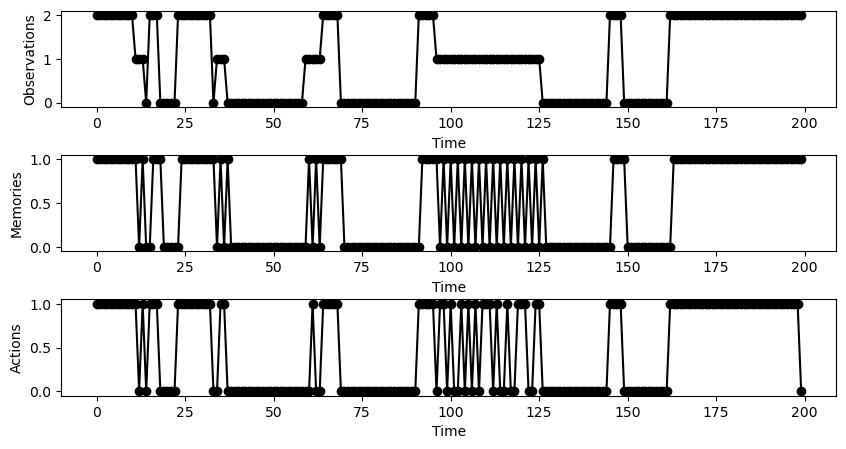

In [228]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = plt.subplots(3,1, figsize=(10,5))
plt.subplots_adjust(hspace=0.5)

ax[0].plot(Time, trj["observations"], 'o', c= 'k')
ax[0].plot(Time, trj["observations"], c = 'k')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Observations')

ax[1].plot(Time, trj["memories"], 'o', c= 'k')
ax[1].plot(Time, trj["memories"], c = 'k')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Memories')

ax[2].plot(Time, trj["actions"], 'o', c= 'k')
ax[2].plot(Time, trj["actions"], c = 'k')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Actions')

plt.show()

In [229]:
FSC.evaluate_nloglikelihood(trajectories[0])

37.730514014022624

In [240]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123456789)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(146.5269, device='mps:0', grad_fn=<SubBackward0>)

In [241]:
_, _ = FSC_tofit.optimize(NEpochs = 10, NBatch = 20, lr = 0.1)

Training with 80 trajectories and validating with 20 trajectories.
	 Epoch 1 - Batch 1 - Loss: 2999.701416015625
	 Epoch 1 - Batch 2 - Loss: 2687.606201171875
	 Epoch 1 - Batch 3 - Loss: 2463.2861328125
	 Epoch 1 - Batch 4 - Loss: 2195.1806640625
Epoch 1 - Training loss: 517.288720703125, Validation loss: 2249.908203125
	 Epoch 2 - Batch 1 - Loss: 2095.522705078125
	 Epoch 2 - Batch 2 - Loss: 1818.33251953125
	 Epoch 2 - Batch 3 - Loss: 1743.7674560546875
	 Epoch 2 - Batch 4 - Loss: 1533.79345703125
Epoch 2 - Training loss: 359.5708068847656, Validation loss: 1613.5625
	 Epoch 3 - Batch 1 - Loss: 1464.46923828125
	 Epoch 3 - Batch 2 - Loss: 1407.78173828125
	 Epoch 3 - Batch 3 - Loss: 1354.2564697265625
	 Epoch 3 - Batch 4 - Loss: 1225.4683837890625
Epoch 3 - Training loss: 272.5987915039062, Validation loss: 1252.34326171875
	 Epoch 4 - Batch 1 - Loss: 1225.8712158203125
	 Epoch 4 - Batch 2 - Loss: 1148.81884765625
	 Epoch 4 - Batch 3 - Loss: 1172.33349609375
	 Epoch 4 - Batch 4 - Los

In [242]:
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(34.4864, device='mps:0', grad_fn=<SubBackward0>)

In [243]:
FSC_tofit.rho.detach().cpu().numpy(), FSC.rho

(array([0.96023947, 0.0397605 ], dtype=float32), array([0.5, 0.5]))

In [244]:
FSC_tofit.TMat.detach().cpu().numpy()[0][0], FSC.TMat[0][0]

(array([[0.9824767 , 0.00166073],
        [0.01287973, 0.00298291]], dtype=float32),
 array([[9.99862450e-01, 4.58498991e-05],
        [4.58498991e-05, 4.58498991e-05]]))

In [245]:
FSC_tofit.TMat.detach().cpu().numpy()[0][1], FSC.TMat[0][1]

(array([[0.55064726, 0.03440857],
        [0.4097581 , 0.00518605]], dtype=float32),
 array([[9.99862450e-01, 4.58498991e-05],
        [4.58498991e-05, 4.58498991e-05]]))

In [236]:
FSC_tofit.TMat.detach().cpu().numpy()[1][0], FSC.TMat[1][0]

(array([[0.32163656, 0.4434191 ],
        [0.15498103, 0.07996324]], dtype=float32),
 array([[2.29270520e-05, 2.29270520e-05],
        [4.99977073e-01, 4.99977073e-01]]))

In [237]:
FSC_tofit.TMat.detach().cpu().numpy()[1][1], FSC.TMat[1][1]

(array([[0.32497084, 0.33524534],
        [0.21613818, 0.12364567]], dtype=float32),
 array([[4.99977073e-01, 4.99977073e-01],
        [2.29270520e-05, 2.29270520e-05]]))

In [238]:
FSC_tofit.TMat.detach().cpu().numpy()[2][0], FSC.TMat[2][0]

(array([[0.00129161, 0.23214458],
        [0.00172466, 0.7648391 ]], dtype=float32),
 array([[4.58498991e-05, 4.58498991e-05],
        [4.58498991e-05, 9.99862450e-01]]))

In [239]:
FSC_tofit.TMat.detach().cpu().numpy()[2][1], FSC.TMat[2][1]

(array([[0.00220393, 0.83368194],
        [0.00128464, 0.16282952]], dtype=float32),
 array([[4.58498991e-05, 4.58498991e-05],
        [4.58498991e-05, 9.99862450e-01]]))